In [4]:
from parcels import ParticleSet
from parcels import JITParticle
from parcels import AdvectionRK4_3D
from parcels import AdvectionRK4
from parcels import Geographic
from datetime import timedelta
import numpy as np
from parcels import FieldSet
from glob import glob

In [2]:
## parameters
## set the number of particles
num_particles = 100

## Set the location of the particles
channel_lon_bds = (0,4.5) # use inmutable objects
channel_lat_bds = (0+1,18-1)

## set the tracking time
days = 30
minutes = 20

## record the particles every timestep of
hours=4


In [3]:
##prepare the files
path1= '/gxfs_work/geomar/smomw662/FESOM_data/channel_interp'

ufiles = sorted(glob(f"{path1}/u.2005.nc"))
vfiles = sorted(glob(f"{path1}/v.2005.nc"))
wfiles = sorted(glob(f"{path1}/w.2005.nc"))

 
lon_start = np.random.uniform(*channel_lon_bds,size=(num_particles,)) 
lat_start = np.random.uniform(*channel_lat_bds, size=(num_particles,))


In [8]:
## define the fieldset
filenames = {"U": ufiles,
             "V": vfiles,
             "W": wfiles,
            }

variables = {"U": "u",
             "V": "v",
             "W": "w",}

dimensions = {'time': 'time',
              'depth': 'z',
              'lat': 'grid_lat',
              'lon': 'grid_lon'}


In [9]:
fieldset = FieldSet.from_netcdf(
    filenames, 
    variables, 
    dimensions,
    time_periodic=False,
    allow_time_extrapolation=False,    
)


In [10]:
## add the Halo
fieldset.add_constant("halo_west", fieldset.U.grid.lon[0])
fieldset.add_constant("halo_east", fieldset.U.grid.lon[-1])
fieldset.add_periodic_halo(zonal=True)
fieldset.U.units = Geographic()
# fieldset.Ustokes.units = GeographicPolar()

def periodicBC(particle,fielset,time):
    if particle.lon < fieldset.halo_west:
        particle_dlon += fieldset.halo_east - fieldset.halo_west
    elif particle.lon > fieldset.halo_east:
        particle_dlon -= fieldset.halo_east - fieldset.halo_west

##check the error
def CheckError(particle, fieldset, time):
    if particle.state >= 50:  # This captures all Errors
        particle.delete()

In [11]:
## Time and depth initial conditios
time_origin=np.array([str(fieldset.time_origin)],dtype='datetime64[ns]')
time = np.repeat(time_origin, num_particles)  # Assign the same time to all particles
depth = np.random.uniform(0,4000, size=num_particles)  # Choose random depths

In [12]:
## initiate pset
pset = ParticleSet(
    fieldset=fieldset,
    pclass=JITParticle,
    lon = lon_start,
    lat = lat_start,
    depth=depth,
    time=time
) 

In [13]:
rnd=str(np.random.randint(1234))

out_path = '/gxfs_work/geomar/smomw662/FESOMparcels_first/data/' #path to store the particle zarr
out_fn = 'Parcels_run_'+rnd

output_file = pset.ParticleFile(name=out_path+out_fn, 
                                outputdt=timedelta(hours=hours))

In [14]:
## Execute particles
pset.execute(
    [AdvectionRK4_3D,periodicBC,CheckError],
    runtime=timedelta(days=days),
    dt=timedelta(minutes=minutes),
    output_file= output_file
)

INFO: Output files are stored in /gxfs_work/geomar/smomw662/FESOMparcels_first/data/Parcels_run_721.zarr.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31104000.0/31104000.0 [02:45<00:00, 187406.77it/s]


In [2]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from cmocean import cm # for oceanography-specific colormaps
from itertools import zip_longest
from functools import reduce
from operator import add
from pathlib import Path
import tqdm

In [5]:
# ds_traj = xr.open_zarr(out_path+out_fn+".zarr")
out_path = '/gxfs_work/geomar/smomw662/FESOMparcels_first/data/' #path to store the particle zarr
ds_traj = xr.open_zarr(out_path+"Parcels_run_721.zarr")
ds_traj = ds_traj.compute()
ds_traj

<xarray.Dataset> Size: 4MB
Dimensions:     (trajectory: 100, obs: 2160)
Coordinates:
  * obs         (obs) int32 9kB 0 1 2 3 4 5 6 ... 2154 2155 2156 2157 2158 2159
  * trajectory  (trajectory) int64 800B 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
Data variables:
    lat         (trajectory, obs) float32 864kB 10.1 10.12 10.14 ... 1.946 1.941
    lon         (trajectory, obs) float32 864kB 3.081 3.114 ... 1.882 1.878
    time        (trajectory, obs) datetime64[ns] 2MB 1960-01-01T23:50:00 ... ...
    z           (trajectory, obs) float32 864kB 942.1 942.8 ... 313.3 313.3
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4_3DperiodicBCCheckError
    parcels_mesh:           spherical
    parcels_version:        3.0.5

In [6]:
def line_between(start,end):
    """Find the intermediate points on a line from (x0,y0) to (x1,y1).

    Parameters
    ------------
    start: tuple
        Contains x0 and y0
    end: tuple
        Contains x1 and y1

    Returns
    --------
    list
        List of all intermediate points (x,y)

    """
    x0,y0 = start
    x1,y1 = end
    #This extracts the individual coordinates from the start and end tuples.
    N = max(abs(x1 - x0) + 1, abs(y1 - y0) + 1) #calculate the number of steps
    #Calculate the incremental step sizes
    dx = (x1 - x0) / (N - 1) #for stepping in lon or x
    dy = (y1 - y0) / (N - 1) #for stepping in lat or y
    #the steps secure the evenly spaced points between the start and end

    #Generate the intermediate points
    xx = (round(x0 + n * dx) for n in range(N))
    yy = (round(y0 + n * dy) for n in range(N))
    #Combines the x and y coordinates into a list of tuples 
    return list(zip(xx,yy))

def line_between_sequence(points):
    """ Fill in lines on all segments of points.

    Parameters
    ----------
    points: list
        List of points (x,y).

    Returns
    -------
    list
        List of points(x,y) with all segments filled in.

    """

    segments = [
    line_between(start,end)[:-1]
    for start, end in zip(points[:-1], points[1:])
    ] + [points[-1:], ]
    return reduce(add, segments)

In [7]:
skip_this_step = abs(ds_traj.lon.diff('obs')) > 4.0
ds_traj_nowrap = ds_traj.where(~skip_this_step)

In [8]:
### Unrolling
ad_lon = 0 + 4.5 * (ds_traj.lon.diff('obs') < -4) - 4.5 * (ds_traj.lon.diff('obs') > 4)
lon_unrolled = (ds_traj.lon + ad_lon.cumsum('obs')) #we accumulate the corrections 
##Binning
Nx = 45 #~4.5
Ny = 180 #~18.0

#Each ghost image band corresponds to an increment of 4.5 longitude units.
#Creates ghost images in left and right 
pix_replica_lon = lon_unrolled.min().compute().data[()] //4.5 , lon_unrolled.max().compute().data[()] //4.5 + 1
pix_x_unrolled = np.arange(pix_replica_lon[0] * Nx, pix_replica_lon[1] * Nx).astype(int)

lon_bds = (int(pix_replica_lon[0] *4.5), int(pix_replica_lon[1] * 4.5))
lat_bds = (0,18)
lon_bds_base = (0,4.5)
lon_bds, lat_bds

((-13, 49), (0, 18))

In [9]:
dens = np.zeros((Ny,Nx), dtype=int)
## check the error of the tranpositn
for traj in tqdm.tqdm(ds_traj.trajectory.isel(trajectory=slice(None,None,1)).data):
    lon_traj = lon_unrolled.sel(trajectory=traj).compute().data
    lat_traj = ds_traj.lat.sel(trajectory=traj).compute().data
    point_list = list(zip(      
        np.digitize(lat_traj, np.linspace(*lat_bds, Ny)).astype(int) -1,
        np.digitize(lon_traj, np.linspace(*lon_bds, int((pix_replica_lon[1] - pix_replica_lon[0]) * Nx))).astype(int)-1,
    ))

    #drop the duplicates
    point_list = [i for i, j in zip_longest(point_list, point_list[1:]) if i !=j]
    pos,count = np.unique(np.array(line_between_sequence(point_list)), axis=0, return_counts = True)
    #wrap back to Nx and Ny
    pos = pos % [Ny,Nx]
    dens[*pos.T] +=count
    #break

100%|████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 339.69it/s]


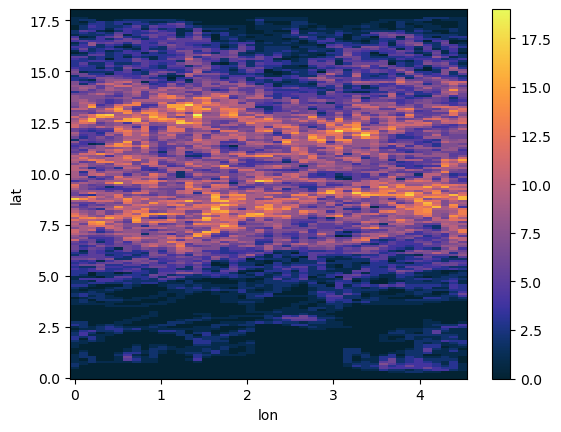

In [14]:
dens_array = xr.DataArray(
    dens,
    dims = ('lat','lon'),
    coords = {
        'lat':np.linspace(*lat_bds, Ny), 
        'lon':np.linspace(*lon_bds_base, Nx), 
    },
)

dens_array.plot.imshow(cmap=cm.thermal)

Text(0, 0.5, 'Latitude')

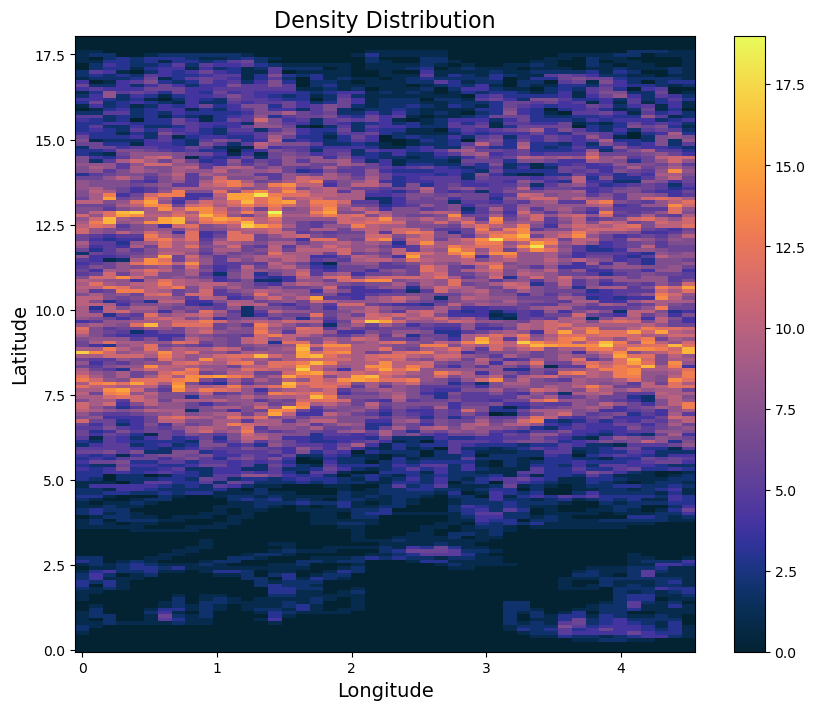

In [15]:
# Plot the data
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the figure size as needed
dens_array.plot.imshow(ax=ax, cmap=cm.thermal)
plt.title("Density Distribution", fontsize=16)  # Add a title if needed
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)

# Save the figure
# plt.savefig("particle_january.png", dpi=300, bbox_inches="tight")  # Save the figure
# plt.show()